In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.join(os.curdir, ".."))

from datasets.compositional_dataset import CompositionalDataset
from scripts.compositional_attention import CompositionalTransformer, ISCompositionalTransformer

# Baseline: Standard Self-Attention

In [2]:
class SelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        attn_output, _ = self.attention(x, x, x)
        output = self.fc(attn_output.squeeze(1))
        return output

class CompositionDatasetTorch(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sample = self.data[idx]
        input_tensor = torch.tensor(sample['input'], dtype=torch.float32)
        output_tensor = torch.tensor(sample['output'], dtype=torch.float32)
        return input_tensor, output_tensor

In [3]:
def train(model, train_loader, test_loader, epochs=10, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []

    pbar = tqdm(range(epochs), desc="Epoch")

    for epoch in pbar:
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_train_loss = total_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

        epoch_test_loss = test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)
        pbar.set_description(
            f"Epoch: {epoch+1}/{epochs}, train loss: {epoch_train_loss}, test loss: {epoch_test_loss}."
        )

    return train_losses, test_losses

In [4]:
dataset_generator = CompositionalDataset(input_dim=8, num_samples=2000, seed=20250415)
dataset = dataset_generator.prepare_datasets()
train_loader = DataLoader(CompositionDatasetTorch(dataset["train_dataset"]), batch_size=32)
test_loader = DataLoader(CompositionDatasetTorch(dataset["test_dataset"]), batch_size=32)

model = SelfAttentionModel(input_dim=8, hidden_dim=32)

In [5]:
EPOCH = 50
train_losses, test_losses = train(model, train_loader, test_loader, epochs=EPOCH, lr=1e-4)

Epoch: 50/50, train loss: 1928.531162109375, test loss: 5134.734882061298.: 100%|██████████| 50/50 [00:05<00:00,  9.91it/s]  


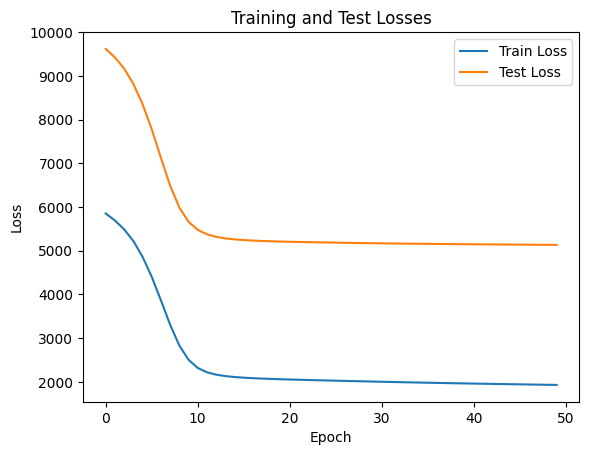

In [6]:
plt.plot(range(EPOCH), train_losses, label='Train Loss')
plt.plot(range(EPOCH), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

# Compositional Attention

In [2]:
def train(model, dataset, epochs=10, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []

    pbar = tqdm(range(epochs), desc="Epoch")

    for epoch in pbar:
        model.train()
        train_loss = 0.0
        for sample in dataset["train_dataset"]:
            x = torch.tensor(sample["input"], dtype=torch.float32)
            y = torch.tensor(sample["output"], dtype=torch.float32)
            composition = sample["composition"]

            optimizer.zero_grad()
            pred = model(x, composition)
            loss = criterion(pred, y.unsqueeze(0))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        epoch_train_loss = train_loss / len(dataset["train_dataset"])
        train_losses.append(epoch_train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for sample in dataset["test_dataset"]:
                x = torch.tensor(sample["input"], dtype=torch.float32)
                y = torch.tensor(sample["output"], dtype=torch.float32)
                composition = sample["composition"]

                pred = model(x, composition)
                loss = criterion(pred, y.unsqueeze(0))
                test_loss += loss.item()
        epoch_test_loss = test_loss / len(dataset["test_dataset"])
        test_losses.append(epoch_test_loss)
        pbar.set_description(
            f"Epoch: {epoch+1}/{epochs}, train loss: {epoch_train_loss}, test loss: {epoch_test_loss}."
        )

    return train_losses, test_losses

In [3]:
dataset_generator = CompositionalDataset(input_dim=8, num_samples=2000, seed=20250415)
dataset = dataset_generator.prepare_datasets()

input_dim = 8
hidden_dim = 32
num_layers = 6
num_heads = 4
basic_functions = dataset["basic_functions"]

model = CompositionalTransformer(input_dim, hidden_dim, num_layers, num_heads, basic_functions)

In [4]:
EPOCH = 50
train_losses, test_losses = train(model, dataset, epochs=EPOCH, lr=1e-4)

Epoch: 50/50, train loss: 1144.109816145897, test loss: 4475.1999420785905.: 100%|██████████| 50/50 [16:19<00:00, 19.59s/it] 


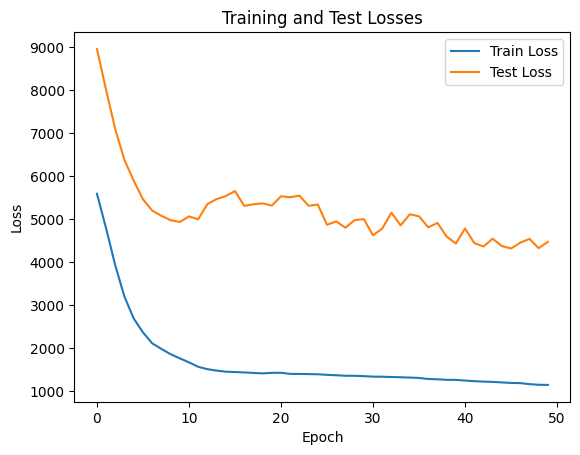

In [5]:
plt.plot(range(EPOCH), train_losses, label='Train Loss')
plt.plot(range(EPOCH), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

# Compositional Attention with Intermediate Step Supervision

In [2]:
def train(model, dataset, epochs=20, lr=1e-3, alpha=0.5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    pbar = tqdm(range(epochs), desc="Epoch")

    for epoch in pbar:
        model.train()
        train_loss = 0.0
        for sample in dataset["train_dataset"]:
            x = torch.tensor(sample["input"], dtype=torch.float32).unsqueeze(0)
            y_final = torch.tensor(sample["output"], dtype=torch.float32).unsqueeze(0)
            y_intermediate = torch.tensor(sample["intermediate_steps"], dtype=torch.float32)
            composition = [sample["composition"]]

            optimizer.zero_grad()
            pred_intermediate, pred_final = model(x, composition)

            loss_final = criterion(pred_final, y_final)
            loss_intermediate = criterion(pred_intermediate.squeeze(0), y_intermediate)

            loss = loss_final + alpha * loss_intermediate

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_losses.append(train_loss / len(dataset["train_dataset"]))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sample in dataset["test_dataset"]:
                x = torch.tensor(sample["input"], dtype=torch.float32).unsqueeze(0)
                y_final = torch.tensor(sample["output"], dtype=torch.float32).unsqueeze(0)
                y_intermediate = torch.tensor(sample["intermediate_steps"], dtype=torch.float32)
                composition = [sample["composition"]]

                pred_intermediate, pred_final = model(x, composition)

                loss_final = criterion(pred_final, y_final)
                loss_intermediate = criterion(pred_intermediate.squeeze(0), y_intermediate)

                loss = loss_final + alpha * loss_intermediate

                val_loss += loss.item()
        val_losses.append(val_loss / len(dataset["test_dataset"]))

        pbar.set_description(
            f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}"
        )

    return train_losses, val_losses


In [3]:
dataset_generator = CompositionalDataset(input_dim=8, num_samples=2000, seed=20250415)
dataset = dataset_generator.prepare_datasets()

input_dim = 8
hidden_dim = 32
num_layers = 6
num_heads = 4
basic_functions = dataset["basic_functions"]
max_comp_len = dataset_generator.max_seq_len

model = ISCompositionalTransformer(input_dim, hidden_dim, num_layers, num_heads, basic_functions, max_comp_len)

In [4]:
EPOCH = 50
all_losses = []
for alpha in [0, 0.33, 0.66, 1]:
    all_losses.append(train(model, dataset, epochs=EPOCH, lr=1e-4, alpha=alpha))

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]/var/folders/4_/qvmycsg54y16pq415bhtxdc40000gn/T/ipykernel_17955/3707233818.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  y_intermediate = torch.tensor(sample["intermediate_steps"], dtype=torch.float32)
Epoch 50/50, Train Loss: 2036.6845, Val Loss: 12636.5342: 100%|██████████| 50/50 [16:39<00:00, 19.99s/it]
Epoch 50/50, Train Loss: 1982.9765, Val Loss: 12814.3886: 100%|██████████| 50/50 [18:28<00:00, 22.17s/it]
Epoch 50/50, Train Loss: 1582.8937, Val Loss: 12960.9808: 100%|██████████| 50/50 [20:14<00:00, 24.30s/it]
Epoch 50/50, Train Loss: 1268.8381, Val Loss: 13691.7792: 100%|██████████| 50/50 [20:49<00:00, 24.99s/it]


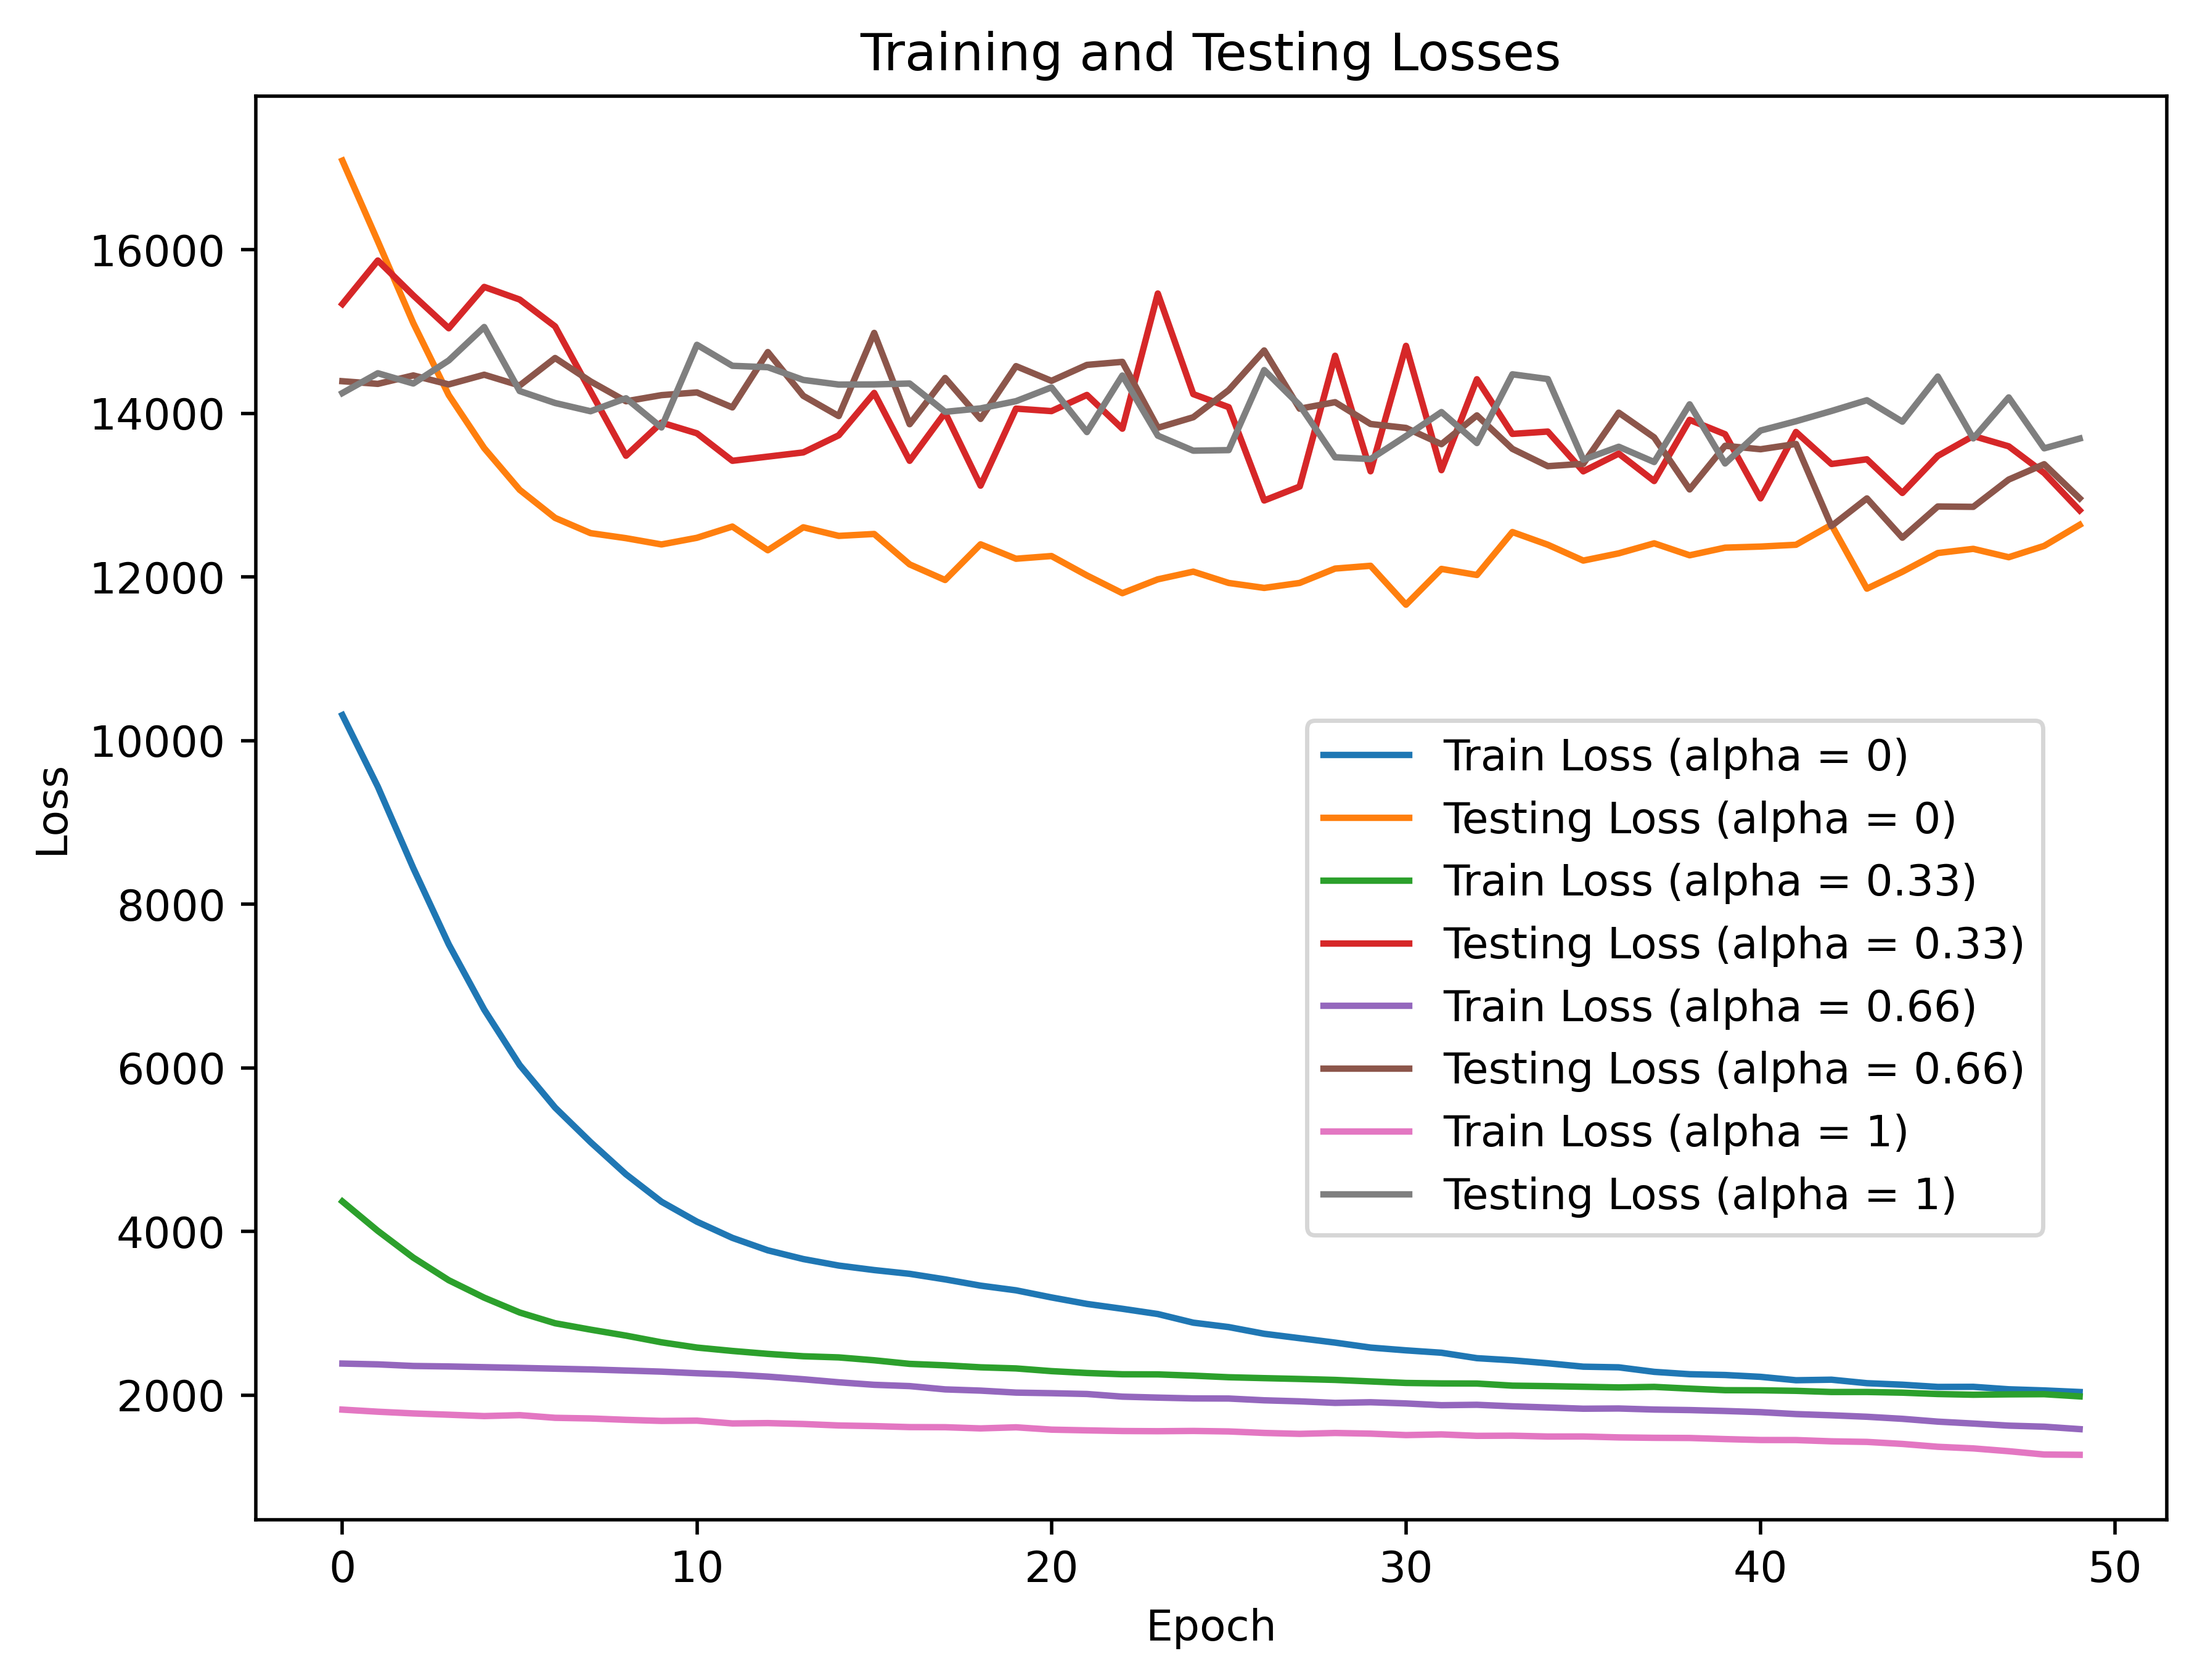

In [6]:
plt.figure(figsize=(8, 6), dpi=500)
for (train_losses, val_losses), alpha in zip(all_losses, [0, 0.33, 0.66, 1]):
    plt.plot(range(EPOCH), train_losses, label=f'Train Loss (alpha = {alpha})')
    plt.plot(range(EPOCH), val_losses, label=f'Testing Loss (alpha = {alpha})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend(loc=(0.55,0.2))
plt.show()